In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import json

from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
from scipy.stats import shapiro
from sklearn.decomposition import PCA

In [3]:
# pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

# Import Data

In [4]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)
data.shape

(1652, 44)

In [100]:
column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

data.columns = column_names

TARGET_NAME = 'Yield_strength'
target = data[TARGET_NAME]

data.iloc[0]

Carbon_concentration                                          0.037
Silicon_concentration                                           0.3
Manganese_concentration                                        0.65
Sulphur_concentration                                         0.008
Phosphorus_concentration                                      0.012
Nickel_concentration                                              0
Chromium_concentration                                          NaN
Molybdenum_concentration                                        NaN
Vanadium_concentration                                          NaN
Copper_concentration                                            NaN
Cobalt_concentration                                            NaN
Tungsten_concentration                                          NaN
Oxygen_concentration                                            NaN
Titanium_concentration                                          NaN
Nitrogen_concentration                          

In [6]:
data.replace('N', np.nan, inplace=True)

# Infos

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Carbon_concentration                  1652 non-null   float64
 1   Silicon_concentration                 1652 non-null   float64
 2   Manganese_concentration               1652 non-null   float64
 3   Sulphur_concentration                 1648 non-null   object 
 4   Phosphorus_concentration              1642 non-null   object 
 5   Nickel_concentration                  697 non-null    object 
 6   Chromium_concentration                784 non-null    object 
 7   Molybdenum_concentration              793 non-null    object 
 8   Vanadium_concentration                928 non-null    object 
 9   Copper_concentration                  578 non-null    object 
 10  Cobalt_concentration                  129 non-null    object 
 11  Tungsten_concentr

# Data Cleaning

## Structural Errors

In [88]:
i = 0
for column in data.columns:
    print(i)
    print(column)
    print(data[column].unique())
    i+=1

0
Carbon_concentration
[0.037  0.044  0.045  0.039  0.041  0.051  0.049  0.038  0.043  0.053
 0.046  0.048  0.074  0.075  0.076  0.068  0.081  0.079  0.078  0.069
 0.08   0.071  0.072  0.066  0.067  0.09   0.088  0.091  0.089  0.094
 0.086  0.04   0.047  0.052  0.05   0.054  0.073  0.077  0.07   0.062
 0.06   0.055  0.059  0.042  0.058  0.065  0.095  0.151  0.147  0.145
 0.061  0.035  0.1    0.12   0.099  0.093  0.101  0.096  0.097  0.03
 0.032  0.031  0.098  0.13   0.11   0.057  0.15   0.064  0.082  0.036
 0.125  0.105  0.115  0.1055 0.14   0.16   0.084  0.092  0.029  0.063
 0.18  ]
1
Silicon_concentration
[0.3   0.31  0.35  0.33  0.32  0.36  0.29  0.34  0.39  0.44  0.48  0.37
 0.51  0.57  0.27  0.45  0.24  0.41  0.46  0.43  0.42  0.52  0.54  0.18
 0.17  0.2   0.22  0.4   0.26  0.25  0.53  0.38  0.28  0.47  0.23  0.16
 0.62  0.68  0.59  0.7   0.56  0.5   0.58  0.66  0.63  0.67  0.61  0.21
 0.49  0.12  0.13  0.15  0.11  0.19  0.14  0.415 0.08  0.04  0.07  0.55
 0.9   0.8   1.14  0.95  

In [8]:
data[data['Weld_ID']=='Pat-1981-S6/BX400']

,Carbon_concentration,Silicon_concentration,Manganese_concentration,Sulphur_concentration,Phosphorus_concentration,Nickel_concentration,Chromium_concentration,Molybdenum_concentration,Vanadium_concentration,Copper_concentration,...,Charpy_temperature,Charpy_impact_toughness,Hardness,50%_FATT,Primary_ferrite_in_microstructure,Ferrite_with_second_phase,Acicular_ferrite,Martensite,Ferrite_with_carbide_aggregate,Weld_ID
1010,0.1,0.24,1.91,0.016,0.016,NaN,NaN,0.02,0.01,0.05,...,NaN,NaN,170(Hv30),NaN,NaN,NaN,NaN,NaN,NaN,Pat-1981-S6/BX400
1011,0.1,0.24,1.91,0.016,0.016,NaN,NaN,0.02,0.01,0.05,...,-60,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pat-1981-S6/BX400
1012,0.1,0.24,1.91,0.016,0.016,NaN,NaN,0.02,0.01,0.05,...,-40,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pat-1981-S6/BX400
1013,0.1,0.24,1.91,0.016,0.016,NaN,NaN,0.02,0.01,0.05,...,-20,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pat-1981-S6/BX400
1014,0.1,0.24,1.91,0.016,0.016,NaN,NaN,0.02,0.01,0.05,...,0,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pat-1981-S6/BX400


- Values < N: choose a random number < N, set the value to N
- Hardness: Cases like 158(Hv30) means a hardness of 158, measured with a 30 kgf load. When it is not specified, it means a default value was used.
- Nitrogen_concentration: Cases like '67tot33res' --> only use the part '67', split in two categories, one for '67' and one for '33'.
- Interpass_temperature: Cases like '150-200' means between 150 and 200

In [153]:
# Copy the initial dataset to apply transformations
data_copy = data.copy()

# Values < N
def replace_less_than_values(df, column):
    if type(df[column].dropna().iloc[0]) == str:  # Check if the column contains string values:
        df[column + '_<'] = df[column].str.contains('<')
        df[column] = df[column].replace(r'<(\d+)', r'\1', regex=True)
    return df
for column in data.columns:
    data_copy = replace_less_than_values(data_copy, column)

# Values like 158(Hv30) or 67tot33res
def split_res_values(value, pattern):
    if isinstance(value, str) and pattern in value:
        # Looking for two numbers in the string 
        numbers = re.findall(r'\d+', value)
        if len(numbers) > 1:
            return float(numbers[0]), float(numbers[1])
        else:
            return float(numbers[0]), np.nan  # If only one number is before "res"
    else:
        try:
            return float(value), np.nan  # If there is no "res", return NaN
        except ValueError:
            return np.nan, np.nan

# Values like 150 - 200
def process_interpass_temperature(value):
        if isinstance(value, str) and '-' in value:
            # Split the range, convert to integers, and calculate the mean
            low, high = map(int, value.split('-'))
            return int((low + high) / 2)
        else:
            # Try converting the value to int, or return NaN if not possible
            try:
                return int(value)
            except (ValueError, TypeError):
                return np.nan
            
# Handling columns with two numerical values 
data_copy['Nitrogen_concentration'], data_copy['Nitrogen_concentration_residual'] =  zip(*data_copy['Nitrogen_concentration'].apply(lambda x:split_res_values(x, 'res')))
data_copy['Hardness'], data_copy['Hardness_load'] =  zip(*data_copy['Hardness'].apply(lambda x:split_res_values(x, 'Hv')))
data_copy['Interpass_temperature'] = data_copy['Interpass_temperature'].apply(process_interpass_temperature)

print(data_copy["Hardness"].info())
# print(data[data['Sulphur_concentration_<'] == True][['Sulphur_concentration', 'Sulphur_concentration_<']])

<class 'pandas.core.series.Series'>
RangeIndex: 1652 entries, 0 to 1651
Series name: Hardness
Non-Null Count  Dtype  
--------------  -----  
138 non-null    float64
dtypes: float64(1)
memory usage: 13.0 KB
None


In [154]:
# Converting string values that are actually numeric
for column in data.columns:
    try:
        data_copy[column] = pd.to_numeric(data_copy[column])
    except Exception:
        continue

# Checking if the the values were converted to float without damaging other columns 
print(data_copy.info())
data_copy.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 86 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Carbon_concentration                    1652 non-null   float64
 1   Silicon_concentration                   1652 non-null   float64
 2   Manganese_concentration                 1652 non-null   float64
 3   Sulphur_concentration                   1648 non-null   float64
 4   Phosphorus_concentration                1642 non-null   float64
 5   Nickel_concentration                    697 non-null    float64
 6   Chromium_concentration                  784 non-null    float64
 7   Molybdenum_concentration                793 non-null    float64
 8   Vanadium_concentration                  928 non-null    float64
 9   Copper_concentration                    578 non-null    float64
 10  Cobalt_concentration                    129 non-null    floa

<bound method NDFrame.head of       Carbon_concentration  Silicon_concentration  Manganese_concentration  \
0                    0.037                   0.30                     0.65   
1                    0.037                   0.30                     0.65   
2                    0.037                   0.30                     0.65   
3                    0.037                   0.31                     1.03   
4                    0.037                   0.31                     1.03   
...                    ...                    ...                      ...   
1647                 0.100                   0.35                     0.90   
1648                 0.088                   0.36                     0.88   
1649                 0.090                   0.34                     0.89   
1650                 0.092                   0.35                     0.90   
1651                 0.180                   0.39                     0.88   

      Sulphur_concentration  Phos

## Duplicates

In [155]:
data_copy.drop_duplicates(inplace=True)

## Missing values

## Imputation

### Concentrations: P (Phosphorus) and S (Sulfur) with mean values

<div class="alert alert-block alert-success">
<b>Why to do this ?</b>
Phosphorus and sulfur are usually present in steel, even if they aren't deliberately added. These elements are often impurities, and their concentrations are small but non-zero in most cases. When their values are missing in the data, the assumption is that they were not measured but still exist at some average level. Thus, the authors use the mean concentration as a reasonable estimate for missing values.

**Source**:
Source: The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b 
</div>

In [163]:
# Instantiate a transformer for mean imputation.
sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

imp_mean = SimpleImputer(strategy='mean')

data_copy[sulphur_and_phosphorus_columns] = imp_mean.fit_transform(data_copy[sulphur_and_phosphorus_columns])

### Other concentrations (e.g., Mn, Ni, etc.) by setting them to 0

<div class="alert alert-block alert-success">
<b>Why to do this ?</b>
These elements are typically added to modify the properties of the steel (e.g., adding Mn for strength, Ni for corrosion resistance). If their concentrations aren't reported in the dataset, the assumption is that these elements were not added intentionally. Since deliberate alloying additions would typically be measured and reported, the absence of data implies that the element is likely present only at trace levels (so very close to zero). This assumption comes from the fact that modern chemical analysis techniques can detect very low concentrations, so if no value was reported, the concentration is negligible.

**Source**:
Source: The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b 
</div>

In [162]:
other_concentration_columns = ["Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration"]

# Initialize SimpleImputer with constant strategy to fill missing values with 0
imputer_zero = SimpleImputer(strategy='constant', fill_value=0)

data_copy[other_concentration_columns] = imputer_zero.fit_transform(data_copy[other_concentration_columns])


### Electrical and mechanical properties

<div class="alert alert-block alert-success">
We assume a normal distribution and check this hypothesis with the pvalue of the shapiro of scipy.stats
We replace missing values with their mean to preserve the data distribution. 

But this approach can be detrimental regarding outliers and reduce the variance.
Another approach could be to replace missing values with random values of the column to keep the distribution without impact the variance.
</div>

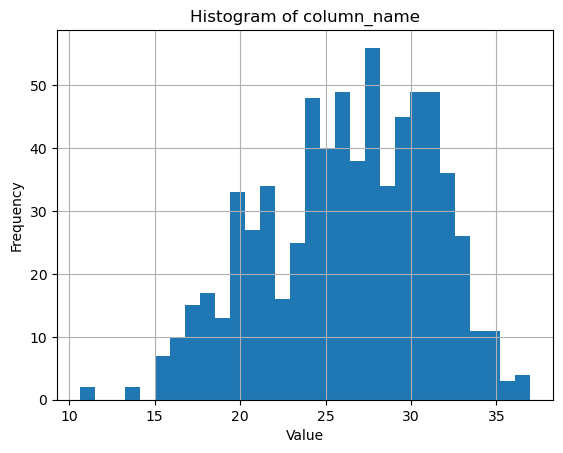

Heat_input does not follow a normal distribution
Interpass_temperature does not follow a normal distribution

  ['Current', 'Voltage', 'Post_weld_heat_treatment_temperature', 'Post_weld_heat_treatment_time', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 'Charpy_impact_toughness', 'Hardness', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate']


In [158]:
electrical_and_mechanical_properties_columns = [
    'Current', 
    'Voltage',
    'Heat_input',
    'Interpass_temperature',
    'Post_weld_heat_treatment_temperature',
    'Post_weld_heat_treatment_time',
    'Elongation', 
    'Reduction_of_Area', 
    'Charpy_temperature', 
    'Charpy_impact_toughness',
    'Hardness', 
    'Primary_ferrite_in_microstructure',
    'Ferrite_with_second_phase',
    'Acicular_ferrite',
    'Martensite',
    'Ferrite_with_carbide_aggregate',
]

normaly_distributed_columns = []

data_copy["Elongation"].hist(bins=30)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of column_name')
plt.show()

# Check if it is reasonable to assume a gaussian distribution 
for column in electrical_and_mechanical_properties_columns:
    stat, p_value = shapiro(data_copy[column])
    if p_value > 0.05:
        normaly_distributed_columns.append(column)
    else:
        print(column, "does not follow a normal distribution")

print("\n ", normaly_distributed_columns)
data_copy[electrical_and_mechanical_properties_columns] = imp_mean.fit_transform(data_copy[electrical_and_mechanical_properties_columns])

# Data Transformation

## Feature selection

### Concentrations

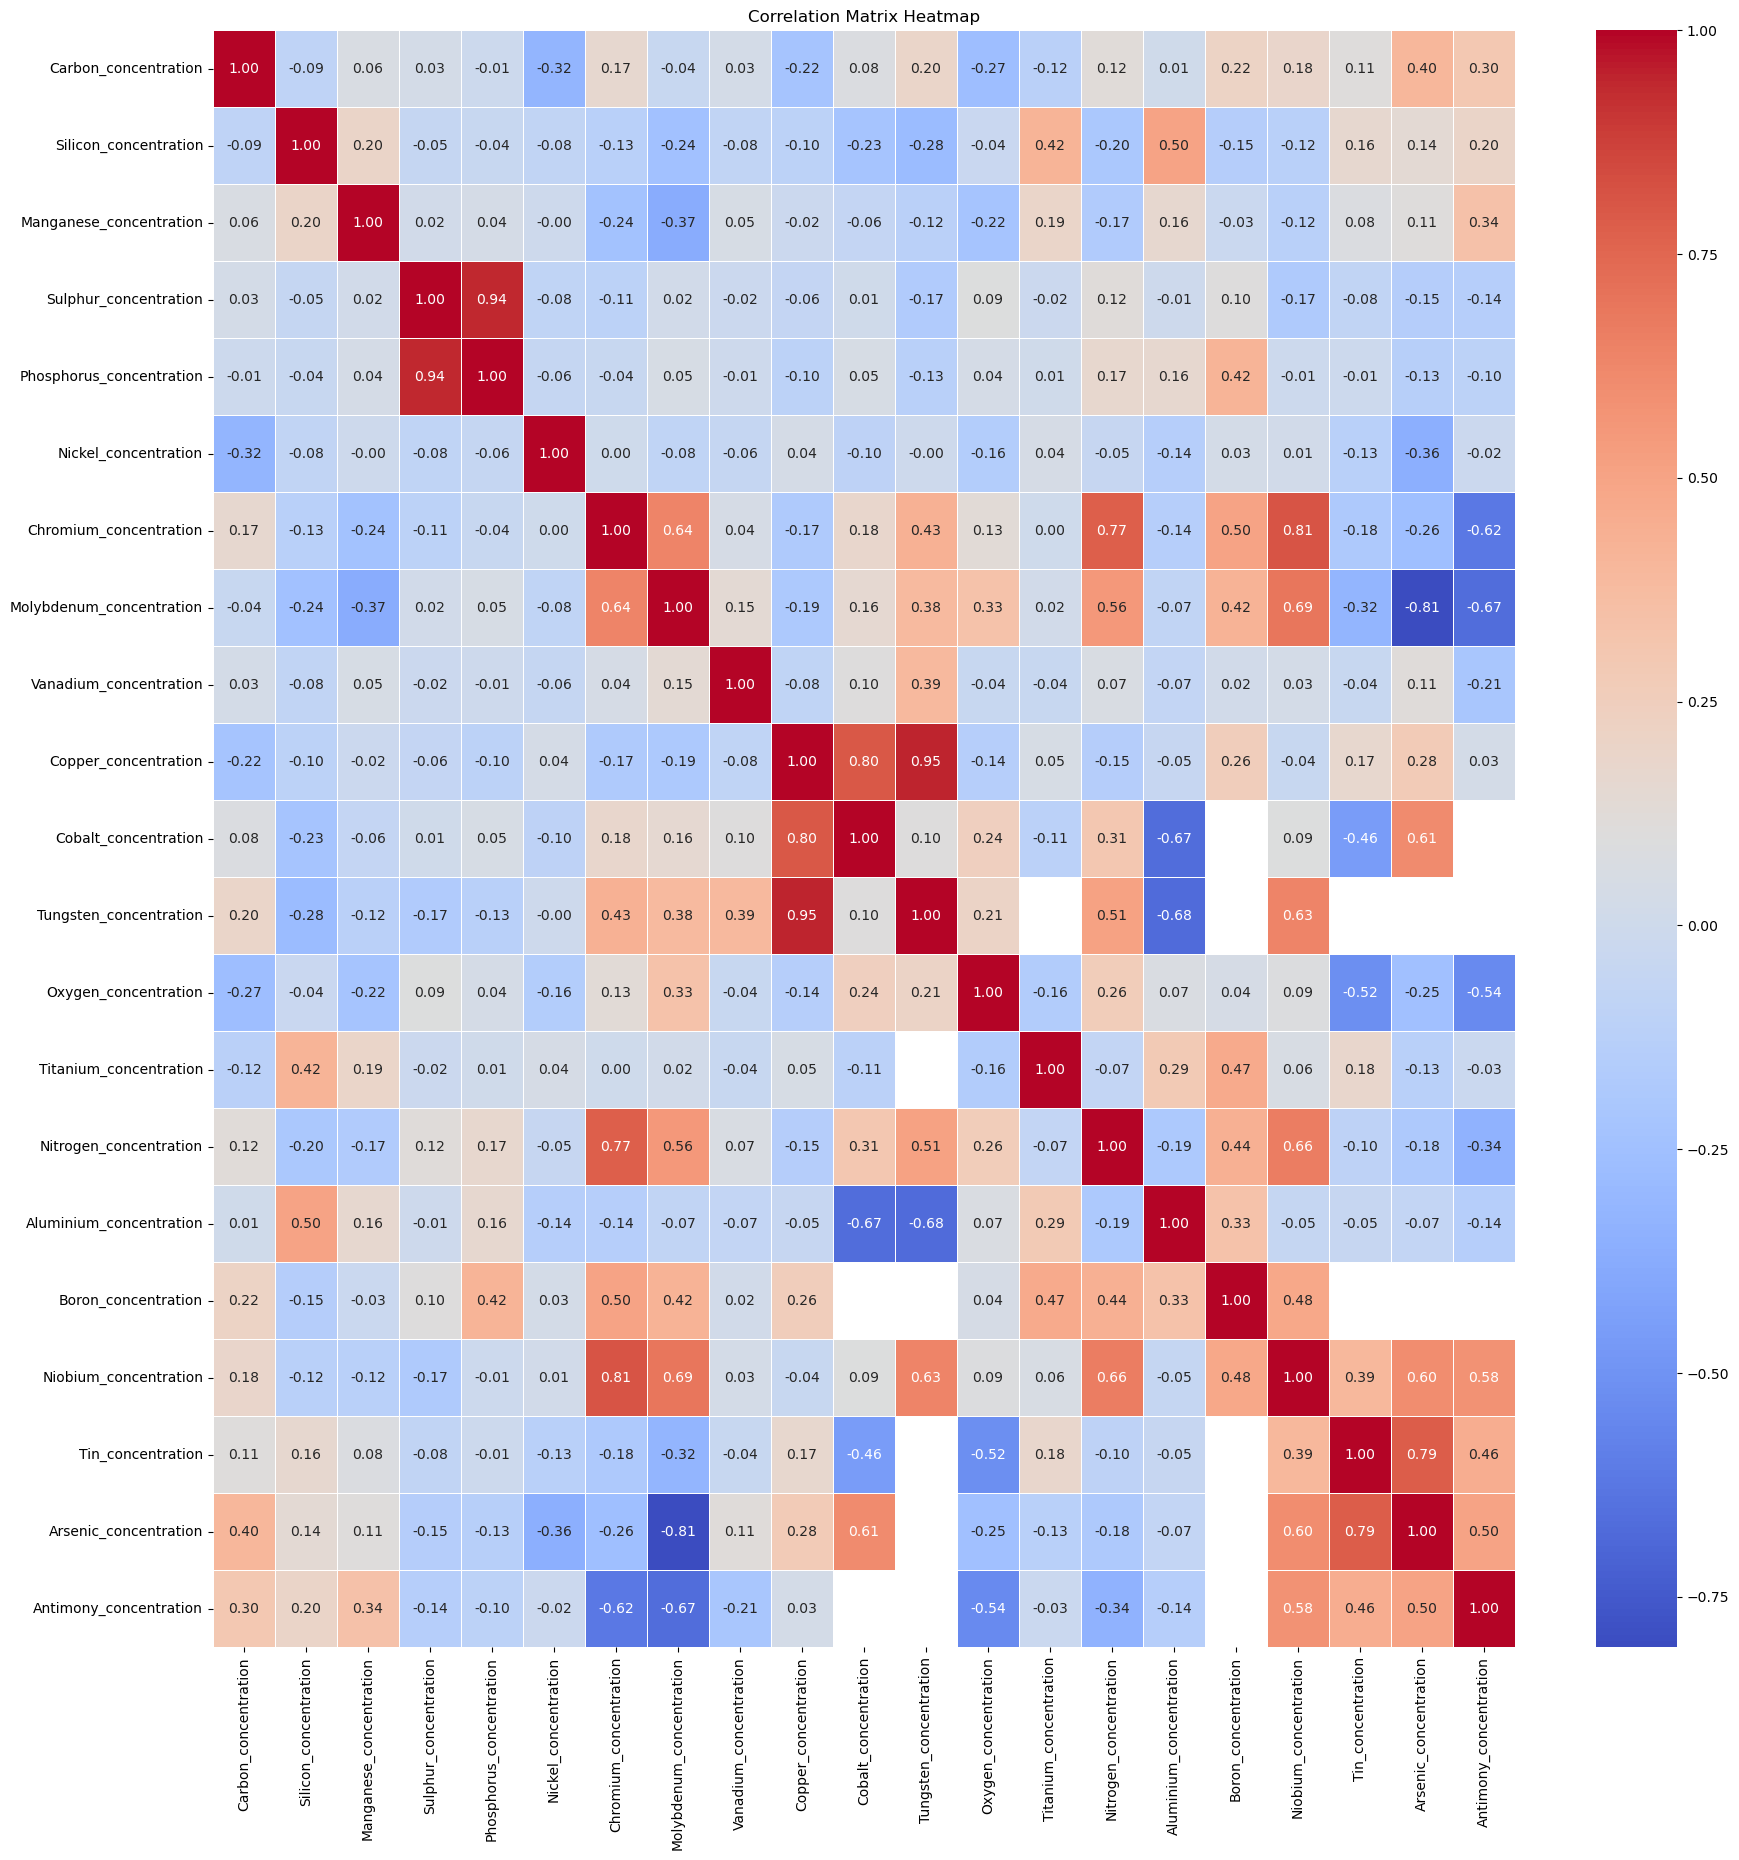

In [160]:
concentration_columns = column_names[0: 21]
correlation_matrix = data_copy[concentration_columns].corr() # By default it is pearson correlation
plt.figure(figsize=(21, 21))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<div class="alert alert-block alert-info">

- Phosphorus and Sulphur concentrations are deeply correlated

- Molybdenum and Chromimum concentrations are correlated 

The rest seems to be not so much correlated. Maybe we can use a PCA approach to reduce the number of features

According to sckit-learn library, we can use PCA with n_components=0.80 and svd_solver="full"

<b> "If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components."</b>

svd_solver = "full" means exact full SVD computes all possible singular values and vectors of the data matrix, even if they might not be needed
</div>

In [164]:
# PCA approach
pca = PCA(n_components=0.80, svd_solver="full")

# Fit PCA on the DataFrame and transform the data
concentration_vector = pca.fit_transform(data_copy[concentration_columns])

# Results
explained_variance_ratio = pca.explained_variance_ratio_  # Variance explained by each component
n_components = pca.n_components_  # Number of components chosen to explain 80% variance

# Convert the transformed data back to a DataFrame
concentration_data = pd.DataFrame(concentration_vector, columns=[f'PC{i+1}' for i in range(n_components)])

# Print results
print(f"Number of components chosen: {n_components}")
print(f"Explained Variance Ratio: {explained_variance_ratio}")
print("\nTransformed Data:")
print(concentration_data)



Number of components chosen: 3
Explained Variance Ratio: [0.49900183 0.26182708 0.12636684]

Transformed Data:
             PC1         PC2        PC3
0    -353.532652   37.674760 -39.134125
1    -353.532652   37.674760 -39.134125
2    -353.532652   37.674760 -39.134125
3    -353.532699   37.674671 -39.133953
4    -353.532699   37.674671 -39.133953
...          ...         ...        ...
1647   90.903333   81.753846 -87.634336
1648  415.356291  904.123657  45.762223
1649   51.351153  -14.534444 -75.397222
1650  201.822745  377.870488 -12.003129
1651  -11.661758    9.225716 -68.972221

[1652 rows x 3 columns]


### Electrical and mechanical properties

<div class="alert alert-block alert-success">
Since we aim at predicting the Yield Strength, it's intersting to look at the correlation between the mechanical features and the Yield Strength to better choose a subset of features.
</div>

In [165]:
# Threshold of acceptable pearson correlations 
CORRELATION_THRESHOLD = 0.15

# Adding target to electrical and mechanical columns
electrical_and_mechanical_properties_columns.append(TARGET_NAME)

electrical_and_mechanical_data = data_copy[electrical_and_mechanical_properties_columns]
correlation_coefficients = {}
for column in electrical_and_mechanical_data.columns:
    X = electrical_and_mechanical_data[[column, TARGET_NAME]].dropna()
    try:
        correlation_coefficients[column] = pearsonr(X[column], X[TARGET_NAME])
    except ValueError:
        correlation_coefficients[column] = None

# Print the corresponding pearson coefficients and p-value
print(json.dumps(correlation_coefficients, indent=4))
columns_to_keep = []
for column in electrical_and_mechanical_properties_columns:
    if correlation_coefficients[column] is not None \
        and abs(correlation_coefficients[column].statistic) > CORRELATION_THRESHOLD \
        and correlation_coefficients[column].pvalue < 0.05:
            columns_to_keep.append(column)

# Electrical and mechanical properties to keep
print("\n Electrical and mechanical properties to keep :", columns_to_keep)

{
    "Current": [
        0.0882409349267636,
        0.013690113696537042
    ],
    "Voltage": [
        0.05812604116237003,
        0.10477334085592811
    ],
    "Heat_input": [
        0.06336142058565114,
        0.07697276099946243
    ],
    "Interpass_temperature": [
        -0.0025305038832859495,
        0.9437480272134579
    ],
    "Post_weld_heat_treatment_temperature": [
        0.13385320660102645,
        0.00017739600154860843
    ],
    "Post_weld_heat_treatment_time": [
        0.009771095835759887,
        0.7852677976559246
    ],
    "Elongation": [
        -0.6143294357133431,
        4.1130501849559965e-82
    ],
    "Reduction_of_Area": [
        -0.39624277954241066,
        1.0015315193293903e-30
    ],
    "Charpy_temperature": [
        0.1304094676656798,
        0.0002603040188782074
    ],
    "Charpy_impact_toughness": [
        -0.1935157922275119,
        5.1080297079670665e-08
    ],
    "Hardness": [
        0.21111759350542908,
        2.6171250

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the corr

<div class="alert alert-block alert-info">
The pvalue of the Pearson correlation must be < 0.05 to be meaningful 

- The *Ultimate_tensile_strength* is deeply correlated with the *Yield Strength*. (0.9)
- The *Hardness* is correlated with the *Yield Strength* (0.81)
- The *Elongation* is correlated with the *Yield Strength* (-0.68)
- *Post_weld_heat_treatment_temperature*, *Post_weld_heat_treatment_time*, *Voltage* and *Current* are poorly correlated to the *Yield Strength*, we can discard them
</div>

In [ ]:
data_with_feature_selection = pd.concat([concentration_data, data_copy[columns_to_keep]], axis = 1)
print(data_with_feature_selection.info(), '\n')
print(data_with_feature_selection.head())


<div class="alert alert-block alert-warning">
At this stage we haven't deal with categorical inputs !
</div>

## Encoding